<a href="https://colab.research.google.com/github/beliaazzhr/Identify-Community-MarvelUniverse/blob/main/Final_Project_AJS_2223_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json

api_token = {"username":"fakhrimftelu","key":"6a8e772a8b6b3555ba34c347c9cde60c"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d csanhueza/the-marvel-universe-social-network
!unzip the-marvel-universe-social-network.zip

the-marvel-universe-social-network.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  the-marvel-universe-social-network.zip
replace edges.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: edges.csv               
  inflating: hero-network.csv        
  inflating: nodes.csv               


In [ ]:
!pip install python-louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import plotly.graph_objects as go
import community.community_louvain as community_louvain
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
hero_network = pd.read_csv('hero-network.csv')
edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
nodes_raw = pd.read_csv("nodes.csv")

Reading data

In [ ]:
print(hero_network.head())

                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL


##**EDA & Preprocessing Data**

In [ ]:
hero_network.isna().sum()

hero1    0
hero2    0
dtype: int64

In [ ]:
for c in ['hero1', 'hero2']:
    hero_network[c] = hero_network[c].apply(lambda x : x[:20].split("/")[0])
edges['hero'] = edges['hero'].apply(lambda x : x[:20].split("/")[0])

In [ ]:
hero_network.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER
2,BLACK PANTHER,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER


In [ ]:
edges.head()

,hero,comic
0,24-HOUR MAN,AA2 35
1,3-D MAN,AVF 4
2,3-D MAN,AVF 5
3,3-D MAN,COC 1
4,3-D MAN,H2 251


##**Rekonstruksi Data**
Rekonstruksi data didasarkan dengan beberapa kriteria berikut:

1. Menampilkan Top 50 heroes berdasarkan jumlah comic
2. Node merupakan hero dan edges merupakan jumlah comic yang muncul

In [ ]:
topn = 50
topn_hero = edges.groupby(['hero'])[['comic']].count().sort_values(by=['comic'], ascending=False).head(topn).index

h1_ = []; h2_ = []; cnt_ = [];
for comb in list(combinations(topn_hero, 2)):    
    temp1 = set(edges[edges['hero']==comb[0]]['comic'])
    temp2 = set(edges[edges['hero']==comb[1]]['comic'])
    cnt = len(temp1.intersection(temp2)) # Appear Together    
    h1_.append(comb[0]); h2_.append(comb[1]); cnt_.append(cnt);
appto_df = pd.DataFrame({'H1':h1_, 'H2':h2_, 'CNT':cnt_})

display(appto_df.head())

,H1,H2,CNT
0,SPIDER-MAN,CAPTAIN AMERICA,145
1,SPIDER-MAN,IRON MAN,95
2,SPIDER-MAN,THING,125
3,SPIDER-MAN,THOR,96
4,SPIDER-MAN,HUMAN TORCH,147


In [ ]:
display(topn_hero)

Index(['SPIDER-MAN', 'CAPTAIN AMERICA', 'IRON MAN', 'THING', 'THOR',
       'HUMAN TORCH', 'MR. FANTASTIC', 'HULK', 'WOLVERINE', 'INVISIBLE WOMAN',
       'SCARLET WITCH', 'BEAST', 'DR. STRANGE', 'WATSON-PARKER, MARY',
       'DAREDEVIL', 'HAWK', 'VISION', 'CYCLOPS', 'WASP', 'JAMESON, J. JONAH',
       'ANT-MAN', 'SUB-MARINER', 'STORM', 'PROFESSOR X', 'FURY, COL. NICHOLAS',
       'MARVEL GIRL', 'COLOSSUS II', 'ANGEL', 'NIGHTCRAWLER', 'ICEMAN',
       'SHE-HULK', 'JARVIS, EDWIN', 'WONDER MAN', 'BLACK WIDOW',
       'ROBERTSON, JOE', 'PARKER, MAY', 'HERCULES [GREEK GOD]', 'QUICKSILVER',
       'SHADOWCAT', 'JONES, RICHARD MILHO', 'ODIN [ASGARDIAN]', 'ROGUE ',
       'BLACK PANTHER', 'SILVER SURFER', 'CANNONBALL II', 'PUNISHER II',
       'CAPTAIN BRITAIN', 'NELSON, FRANKLIN FOG', 'DR. DOOM',
       'RICHARDS, FRANKLIN B'],
      dtype='object', name='hero')

##**Network**
Menampilkan network dengan data yang sudah direkonstruksi.

Notes:

1. Ukuran node merepresentasikan PageRank centrality
2. Tebal edge merupakan jumlah komik kedua heroes muncul secara bersamaan

In [ ]:
COLOR = {
    'SPIDER-MAN':'darkred',
    'IRON MAN':'gold',
    'THOR':'lightblue',
    'DR. STRANGE':'pink',
    'HAWKEYE':'purple',
    'WOLVERINE':'yellow',
    'VISION':'red',
    'ANT-MAN':'red',
    'SCARLET WITCH':'red',
    'CAPTAIN AMERICA':'blue'
}

marvel_net = nx.Graph() 
for i, row in appto_df.iterrows():
    marvel_net.add_edge(row['H1'], row['H2'], weight=row['CNT'])

pos_ = nx.spring_layout(marvel_net, seed=27)
cent_ = nx.pagerank(marvel_net, weight='weight') # Page Rank
cent_top = sorted(cent_.items(), key=lambda item: item[1], reverse=True)[:1]    

In [ ]:
def make_edge(x, y, text, width):
    return go.Scatter(x=x, y=y, line=dict(width=width, color='lightgray'), 
                       hoverinfo='text', text=([text]), mode='lines')

In [ ]:
#Tambahkan semua edge traces
edge_trace = []
for edge in marvel_net.edges():    
    if marvel_net.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]
        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]
        trace  = make_edge([x0, x1, None], [y0, y1, None], None, 
                           width=5*(marvel_net.edges()[edge]['weight']/appto_df['CNT'].max()))
        edge_trace.append(trace)

node_trace = go.Scatter(x=[], y=[], text=[], textposition="top center", textfont_size=10, mode='markers+text', hoverinfo='none',
                        marker=dict(color=[], size=[], line_width=[], line_color=[]))

In [ ]:
for node in marvel_net.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    color = 'gray'
    line_width = 2
    line_color = 'darkgray'
    name_text = node
    
    if node in COLOR:
        color = COLOR[node] 
        line_color='black'
        
    if node in [v[0] for v in cent_top]:
        name_text = '<b>' + node + '</b>'
        
    node_trace['marker']['color'] += tuple([color])
    node_trace['marker']['size'] += tuple([int(400*cent_[node])])
    node_trace['marker']['line_width'] += tuple([line_width])
    node_trace['marker']['line_color'] += tuple([line_color])
    node_trace['text'] += tuple([name_text])

In [ ]:
layout = go.Layout(
    paper_bgcolor='rgba(255,255,255,255)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis =  {'showgrid': False, 'zeroline': False},
    yaxis = {'showgrid': False, 'zeroline': False},
)

In [ ]:
fig = go.Figure(layout = layout)
# Menambahkan traces
for trace in edge_trace:
    fig.add_trace(trace)
fig.add_trace(node_trace)
fig.update_layout(showlegend = False)
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
fig.update_layout(title=f"<b>Top {topn} Heroes Network</b>")
fig.show()

In [ ]:
print(f"The number of hero pairs that never came out together : {len(appto_df[appto_df['CNT']==0])}")

cent_df = pd.DataFrame(index=list(marvel_net.nodes()))

# pagerank
cent_ = nx.pagerank(marvel_net, weight='weight')
cent_df['w_pagerank_cent'] = pd.Series(index=[k for k, v in cent_.items()], data=[float(v) for k, v in cent_.items()])

# eigenvalue centrality
cent_ = nx.eigenvector_centrality(marvel_net, weight='weight')
cent_df['w_eigenvector_cent'] = pd.Series(index=[k for k, v in cent_.items()], data=[float(v) for k, v in cent_.items()])

# degree centrality
cent_ = {h:0.0 for h in marvel_net.nodes()}
for u, v, d in marvel_net.edges(data=True):
    cent_[u]+=d['weight']; cent_[v]+=d['weight'];
cent_df['w_degree_cent'] = pd.Series(index=[k for k, v in cent_.items()], data=[float(v) for k, v in cent_.items()])

# betweenness centrality
cent_ = nx.betweenness_centrality(marvel_net, weight='weight')
cent_df['w_betweenness_cent'] = pd.Series(index=[k for k, v in cent_.items()], data=[float(v) for k, v in cent_.items()])

display(cent_df)
cent_df = cent_df.drop(columns=['w_betweenness_cent'])

The number of hero pairs that never came out together : 30


,w_pagerank_cent,w_eigenvector_cent,w_degree_cent,w_betweenness_cent
SPIDER-MAN,0.033581,0.132569,4295.0,0.000000
CAPTAIN AMERICA,0.042255,0.292654,6317.0,0.000000
IRON MAN,0.033135,0.246704,4913.0,0.000000
THING,0.033571,0.257469,4986.0,0.000000
THOR,0.030904,0.212365,4404.0,0.000000
HUMAN TORCH,0.033176,0.255049,4921.0,0.000000
MR. FANTASTIC,0.032353,0.251811,4793.0,0.000000
HULK,0.018721,0.103353,2454.0,0.000000
WOLVERINE,0.026606,0.130848,3734.0,0.000000
INVISIBLE WOMAN,0.030783,0.241982,4548.0,0.000000


In [ ]:
# Scaling
for c in cent_df.columns:
    s = MinMaxScaler()
    cent_df[[c]] = s.fit_transform(cent_df[[c]])  
cent_df['mean_cent'] = cent_df.mean(axis=1)
cent_df = cent_df.sort_values(by=['mean_cent'], ascending=False)

# Visualization
fig = go.Figure(data=[go.Bar(
    x=cent_df.index,
    y=cent_df['mean_cent'],
    marker_color=[COLOR['CAPTAIN AMERICA']]+['lightgray']*2+\
                 [COLOR['IRON MAN']]+['lightgray']*5+\
                 [COLOR['THOR']]+['lightgray']*2+\
                 [COLOR['SPIDER-MAN']]+['lightgray']*3+\
                 [COLOR['DR. STRANGE']]+['lightgray']*2
)])
fig.update_layout(title_text='<b>Mean Centrality</b>', template='simple_white')

##**Bipartite Graph**

In [ ]:
# Memisahkan node hero dengan komik
comic_node = nodes_raw['node'][nodes_raw['type'] == 'comic'].unique()
hero_node = nodes_raw['node'][nodes_raw['type'] == 'hero'].unique()

# Membuat data edge sebagai 2-tuple
edges_tuple = edges.values.tolist()
edges_tuple = [tuple(x) for x in edges_tuple]

# Mengubah numpyarray menjadi list
comic_node_list = comic_node.tolist()
hero_node_list = hero_node.tolist()

# Membuat graf networkX kosong
bipart = nx.Graph()

# Menambahkan nodes
bipart.add_nodes_from(comic_node_list, bipartite=0)
bipart.add_nodes_from(hero_node_list, bipartite=1)
bipart.add_node("SPIDER-MAN/PETER PARKER", bipartite=1) # Menambahkan satu node karena tidak ditambahkan oleh fungsi sebelumnya

# Menambahkan edges
bipart.add_edges_from(edges_tuple)

# Memisahkan nodes
top_nodes = {n for n, d in bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes = set(bipart) - top_nodes

In [ ]:
# Visualisasi Bipartit
plt.figure(figsize=(70, 30))
pos = nx.drawing.layout.bipartite_layout(bipart, top_nodes, align='horizontal')
nx.draw(bipart, pos=pos, node_size=10, node_color='lightgreen', alpha=0.01)
nx.draw_networkx_labels(bipart, pos=pos, font_size=3)
plt.show()

##**Louvain**

<ipython-input-24-ed16f48d88c9>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



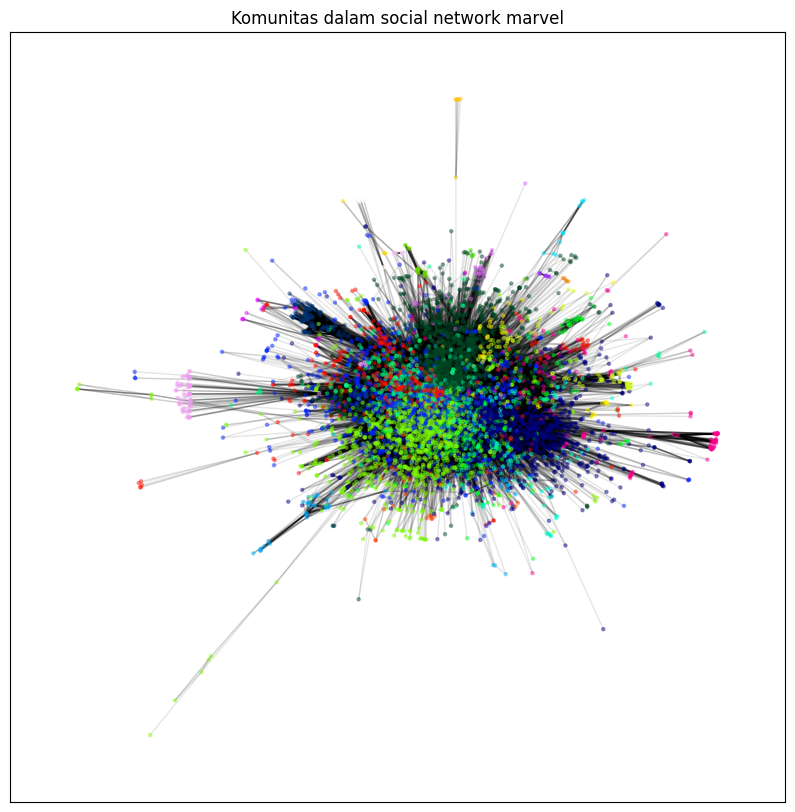

In [ ]:
# Visualisasi komunitas dengan metode louvain

# Ekstrak semua nodes yang berhubungan
hero_graph = nx.algorithms.bipartite.projected_graph(bipart, hero_node_list, multigraph=False)
Gcc = hero_graph.subgraph(sorted(nx.connected_components(hero_graph), key=len, reverse=True)[0])

# Mempartisi komunitas
partition_hero = community_louvain.best_partition(Gcc)

# Memberikan warna untuk komunitas
cmap = cm.get_cmap('gist_ncar', max(partition_hero.values()) + 1)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(Gcc, seed=1103)
nx.draw_networkx_nodes(Gcc, pos, partition_hero.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_hero.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Komunitas dalam social network marvel")
plt.show()

In [ ]:
hero_graph = nx.algorithms.bipartite.projected_graph(bipart, hero_node_list, multigraph=False)
Gcc = hero_graph.subgraph(sorted(nx.connected_components(hero_graph), key=len, reverse=True)[0])

# Mempartisi komunitas
partition_hero = community_louvain.best_partition(Gcc)
print(partition_hero)

{'ABBOTT, JACK': 20, 'ABCISSA': 1, 'ABEL': 1, 'ABOMINATION | MUTANT': 2, 'ABOMINATRIX': 3, 'ABRAXAS': 4, 'ABSALOM': 1, 'ABSORBING MAN | MUTA': 2, 'ACBA': 14, 'ACHEBE, REVEREND DOC': 20, 'ACHILLES': 6, 'ADAM 3,031': 4, 'ADAMS, CINDY': 3, 'ADAMS, CONGRESSMAN H': 20, 'ADAMS, GEORGE': 7, 'ADAMS, MARTHA': 7, 'ADAMS, NICOLE NIKKI': 20, 'ADAMSON, JASON': 3, 'ADAMSON, REBECCA': 3, 'ADAM X': 1, 'ADORA CLONE': 7, 'ADORA': 7, 'ADRIA': 8, 'ADVA': 6, 'ADVERSARY': 1, 'AENTAROS': 1, 'AFTERLIFE': 8, 'AGAMEMNON': 6, 'AGAMOTTO': 8, 'AGARN, CAPT.': 10, 'AGED GENGHIS': 8, 'AGEE, DR. AUBREY': 1, 'AGEE, REBECCA': 1, 'AGGAMON': 8, 'AGINAR': 6, 'AGON': 3, 'AGUIRRE, ISOBEL': 3, 'A': 1, 'AHQLAU': 6, 'AHURA': 3, 'AI-CHIA': 1, 'AINET': 1, 'AJAX': 10, 'AJAX II': 9, "AJES'HA": 9, 'AKAFE': 20, 'AKULIA': 12, 'AKUTAGAWA, OSAMU': 3, 'ALANYA': 13, 'ALBERIK': 14, 'ALBERT': 1, 'ALBUQUERQUE, JEREMIA': 13, 'ALDEN, PROF. MEREDIT': 13, 'ALEGRIA, RICHIE': 1, 'ALEXANDER, CALEB': 16, 'ALEXANDER, CARRIE': 16, 'ALFY': 1, 'ALIOTH':

<ipython-input-25-9870aab34227>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



KeyboardInterrupt: ignored

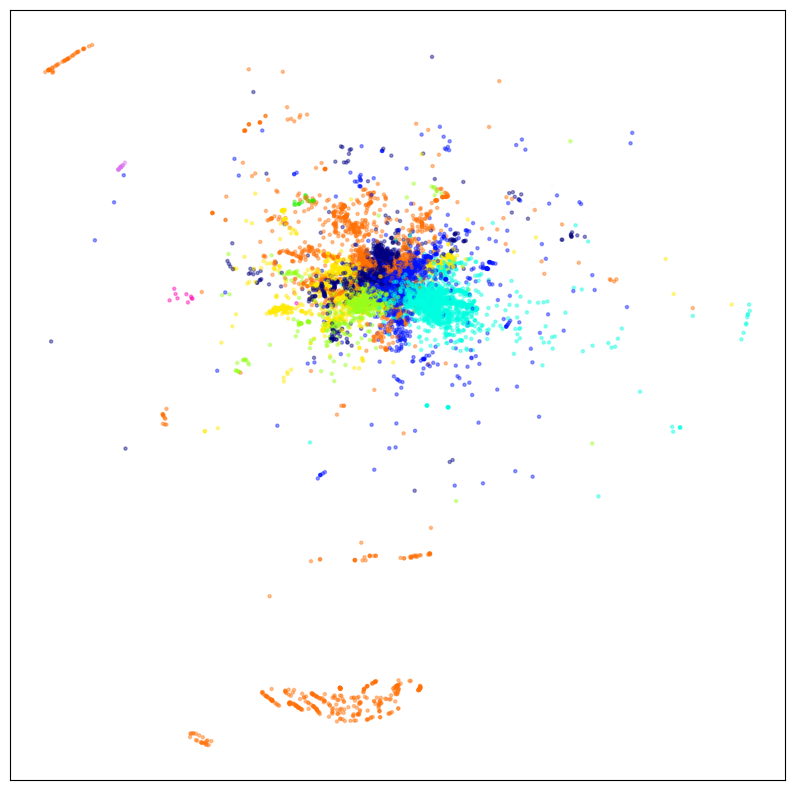

In [ ]:
# Visualisasi komunitas dengan metode louvain

# Ekstrak semua nodes yang berhubungan
comic_graph = nx.algorithms.bipartite.projected_graph(bipart, comic_node_list, multigraph=False)
Gcc = comic_graph.subgraph(sorted(nx.connected_components(comic_graph), key=len, reverse=True)[0])

# Mempartisi komunitas
partition_hero = community_louvain.best_partition(Gcc)

# Memberikan warna untuk komunitas
cmap = cm.get_cmap('gist_ncar', max(partition_hero.values()) + 1)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(Gcc, seed=1103)
nx.draw_networkx_nodes(Gcc, pos, partition_hero.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_hero.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Komunitas dalam social network marvel")
plt.show()